This notebook fits the diffraction geometry + module geometry to a series of powder patterns (with different beam centers)

In [1]:
# %matplotlib widget
import matplotlib.pyplot as pl
from datetime import datetime
import time
start = time.time()
import numpy as np, os
print(np.__version__)
from ImageD11 import transform
from ImageD11.transformer import transformer
from ImageD11.parameters import read_par_file
from ImageD11.columnfile import columnfile
import h5py
import scipy.optimize
import fabio
%matplotlib inline

1.23.0


In [2]:
wl = 0.9762535309700807
12.3985/12.700082106417474 # keV : approximate wavelength
12.3985/wl # Å : approximate energy


12.700082106417474

In [3]:
# choose the frames from 6 frames
# frms = [1,2,3,4,5,6]
frms = [1,2,3,4]
frms

[1, 2, 3, 4]

-----pks----- (108985,)
---filtered--- (100948,)
np.unique(c.ihkl2) [ 3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 16.]

-----pks----- (104170,)
---filtered--- (96447,)
np.unique(c.ihkl2) [ 3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 16. 17. 18.]

-----pks----- (101115,)
---filtered--- (93589,)
np.unique(c.ihkl2) [ 3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 16. 17. 18. 19.]

-----pks----- (93707,)
---filtered--- (86144,)
np.unique(c.ihkl2) [ 3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 16. 17. 18. 19. 20.]



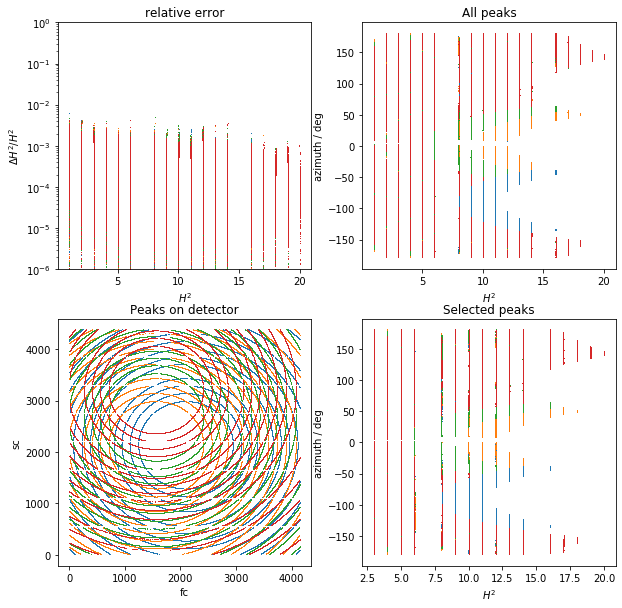

In [4]:
# created via moduleSpatialPeakSearch
f, ((a3, a4),(a1,a2)) = pl.subplots(2,2,figsize=(10,10))
cf = {}
a0 = 4.15682600
ds0 = a0*a0
for i in frms:
    # Load the peaks and parameters:
    c = columnfile( 'eigerSpatial/flt/%d_clean.flt'%(i) )
    print('-----pks-----', c.sc.shape)
    c.parameters.loadparameters('eigerSpatial/par/%d_fit.par'%(i) )
    c.updateGeometry()
    # Create column of frame number
    c.addcolumn(np.ones(c.nrows)*i,'frame')
    # (d*_obs)^2 / (a_0)^2 from cubic hkl to d-spacing formula
    c.addcolumn(np.ones(c.nrows)*c.ds**2*ds0,'hkl2')
    # nearest integers == fit target values
    c.addcolumn(np.round(c.hkl2),'ihkl2')
    # something like a strain
    se = abs( c.ihkl2 - c.hkl2 )/np.where( c.ihkl2 > 0, c.ihkl2, 1)
    a3.plot(c.hkl2, se, ",")
    a4.plot(c.hkl2, c.eta, ",")
#    c.filter((c.Number_of_pixels>7) & (c.ihkl2>0) &  (se<6e-3) )
    c.filter((c.Number_of_pixels>7) & (c.ihkl2>2) &  (se<6e-3) ) # original
    print('---filtered---', c.sc.shape)
    a1.plot(c.fc,c.sc,',')
    a2.plot(c.hkl2,c.eta,',')
    cf[i] = c
    print('np.unique(c.ihkl2)', np.unique(c.ihkl2))
    print()
    uihkl2 = np.unique(c.ihkl2)
a1.set(title='Peaks on detector', ylabel='sc', xlabel='fc')
a2.set(title='Selected peaks', ylabel='azimuth / deg', xlabel='$H^2$')
a3.set(yscale='log', ylim=(1e-6,1), title='relative error', ylabel='$\Delta H^2/H^2$', xlabel='$H^2$')
_ = a4.set(title='All peaks', ylabel='azimuth / deg', xlabel='$H^2$')


In [5]:
# put together all of the peaks:
allpks = np.concatenate( [cf[f].bigarray for f in frms], axis=1)
# ... and place them into an ImageD11 colummfile object
allc = c.copy()
allc.set_bigarray(allpks)
allc.nrows, np.sum([cf[f].nrows for f in frms])

(377128, 377128)

(377128,)
(377128,)
3.0659975928841927


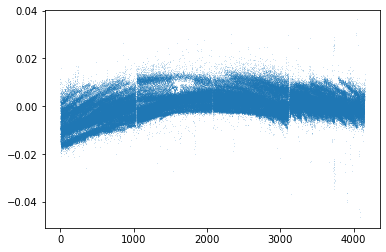

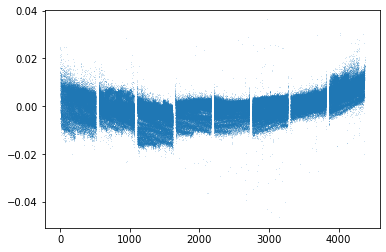

In [6]:
# Remove "bad" peaks from virtual shared pixels
# for col in 255.5, 513.5, 771.5, 1295.5, 1553.5, 1811.5:
#     allc.filter(abs(allc.fc-col)>2.1)
# for row in 255.5, 805.5, 1355.5, 1905.5:
#     allc.filter(abs(allc.sc-row)>2.1)
pl.figure(2)
print(allc.fc.shape)
print(allc.sc.shape)
print(np.linalg.norm(allc.ihkl2-allc.hkl2))
# print(allc,allc.fc,allc.ihkl2, allc.hkl2)
pl.plot(allc.fc,allc.ihkl2-allc.hkl2, ',', alpha=0.2)
pl.figure()
pl.plot(allc.sc,allc.ihkl2-allc.hkl2, ',', alpha=0.2)

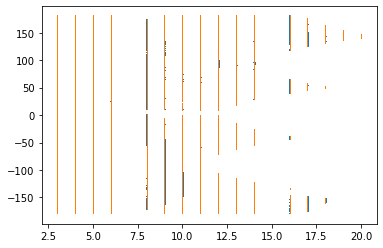

In [7]:
pl.figure()
pl.plot(allc.hkl2,allc.eta,',')
pl.plot(allc.ihkl2,allc.eta,',')

In [8]:
frm = np.unique(allc.frame)
modu = np.unique(allc.module)
print(frm, modu)

[1. 2. 3. 4.] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]


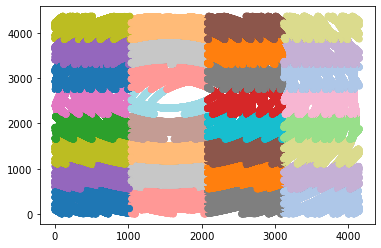

In [9]:
pl.figure()
pl.scatter( allc.f_raw, allc.s_raw, c=(allc.module * 7)%20, cmap='tab20')

In [10]:
# set up a fitting problem : these parameters will be fed to the calchkl2 routine below

# distance, tilts, centers for each image 
pars = [ ]
pnames = [ ]
for f in frm:
    pars.append( cf[f].parameters.get('distance') / a0 ) # distance scaled on lattice
    pnames.append( '%d:distance/a'%(f) )
    for pname in 'y_center z_center tilt_y tilt_z'.split():
        pars.append( cf[f].parameters.get(pname) )
        pnames.append( '%d:%s'%(f, pname) )

pars.append( a0 ) # effectively the wavelength
pnames.append( 'a0' )
framepars = len(pars)
nframes = len(cf.keys())
pars += [0. for i in range(31*3)] # 32 module centers and tilts, BUT LAST IS FIXED
pnames += ["M[%d,%d]"%(i,j) for i in range(31) for j in range(3) ]
print()
print()
for n,v in zip(pnames, pars):
    print(n,v)
# offset, rotation for each module



1:distance/a 35.3556708881609
1:y_center 2093.9167174949507
1:z_center 2119.8048975843026
1:tilt_y 0.0008250432642969382
1:tilt_z -0.001573846768480525
2:distance/a 35.359495419014884
2:y_center 1560.3491893676737
2:z_center 2119.676633223843
2:tilt_y 0.0008407254190670882
2:tilt_z -0.0011815840302926027
3:distance/a 35.36538543280962
3:y_center 1560.4255179876511
3:z_center 2659.9918449865845
3:tilt_y 0.0011286196742781736
3:tilt_z -0.0011674715446387085
4:distance/a 35.3759733728061
4:y_center 1560.3738385564748
4:z_center 3192.9279145720966
4:tilt_y 0.0013298641253150338
4:tilt_z -0.001037154560259057
a0 4.156826
M[0,0] 0.0
M[0,1] 0.0
M[0,2] 0.0
M[1,0] 0.0
M[1,1] 0.0
M[1,2] 0.0
M[2,0] 0.0
M[2,1] 0.0
M[2,2] 0.0
M[3,0] 0.0
M[3,1] 0.0
M[3,2] 0.0
M[4,0] 0.0
M[4,1] 0.0
M[4,2] 0.0
M[5,0] 0.0
M[5,1] 0.0
M[5,2] 0.0
M[6,0] 0.0
M[6,1] 0.0
M[6,2] 0.0
M[7,0] 0.0
M[7,1] 0.0
M[7,2] 0.0
M[8,0] 0.0
M[8,1] 0.0
M[8,2] 0.0
M[9,0] 0.0
M[9,1] 0.0
M[9,2] 0.0
M[10,0] 0.0
M[10,1] 0.0
M[10,2] 0.0
M[11,0] 

In [11]:
def module(a,i,j):
    #p = padding around the outside for debug
    fs = 1030
    ss = 514
    fo = [ 0,  10,   20,   30]
    so = [ 0, 37, 2*37, 37*3, 37*4, 37*5, 37*6, 37*7]
    f = fs*j + fo[j]
    s = ss*i + so[i]
    return a[s:s+ss,f:f+fs]

def module_center( i, j ):
    fs = 1030
    ss = 514
    fo = np.array([ 0,  10,   20,   30])
    so = np.array([ 0, 37, 2*37, 37*3, 37*4, 37*5, 37*6, 37*7])
    return so[i] + ss*(i+0.5), fo[j] + fs*(j+0.5)

def mp31_32( p31 ):
    """ Compute the parameters of module 16 from the other 15 
    We set the sum of all 16 to be zero
    """
    p32 = np.array(list(p31) + [0,0,0]).reshape( (32, 3) ) 
    p32[-1,:] = -np.sum(p32, axis=0) # last module is fixed to make mean zero
    # print('p32.shape',p32.shape)
    return p32
    
    
def do_spatial(s_raw, f_raw, m, modpars):
    """
    s_raw = co-ordinate in the slow pixel direction
    f_raw = co-ordinate in the fast pixel direction
    m = module for this peak (in the range 0,31 for Eiger16M)
    modpars = spatial parameters (offset_slow, offset_fast, angle_rad)
    """
    j = m // 8
    i = m % 8
    cs, cf = module_center( i, j )
    shift_s = np.array( modpars[:,0] )
    shift_f = np.array( modpars[:,1] )
    ds = s_raw[:] - cs + shift_s[m]
    df = f_raw[:] - cf + shift_f[m]
    rotates = modpars[:,2]
    sinr = np.sin(rotates)
    cosr = np.cos(rotates)
    dsr =  cosr[m] * ds  + sinr[m] * df
    dfr = -sinr[m] * ds  + cosr[m] * df
    sc = dsr + cs
    fc = dfr + cf
    return sc,fc    

def calchkl2( colf, *args ):
    """
    colf = columnfile (table) containing labelled peaks
    *args = parameters to be fitted
    """
    fpars = np.array(list(args))
    global framepars, frm # above
    modpars = mp31_32(fpars[framepars:]) # make last module == sum of previous
    ycalc = np.zeros(colf.nrows, float)
    # apply the current spatial correction
    m = colf.module[:].astype(int)
    
    sc, fc = do_spatial( colf.s_raw, colf.f_raw, m, modpars )
    w = 0.9762535309700807
    a0 = fpars[framepars-1]
    for k,rf in enumerate(frm):
        f = int(rf)
        lo = np.searchsorted( colf.frame, f )   # assume data still sorted by frame
        hi = np.searchsorted( colf.frame, f+1 )
        # compute x,y,z laboratory
        x,y,z = transform.compute_xyz_lab( (sc[lo:hi], fc[lo:hi]), 
                                               distance = fpars[k*5]*a0, # take out ds0 again
                                               y_center = fpars[k*5+1],
                                               z_center = fpars[k*5+2],
                                               y_size=0.075, z_size=0.075,
                                               tilt_y = fpars[k*5+3],
                                               tilt_z = fpars[k*5+4],
                                               tilt_x = 0,
                                               o11=1,o12=0,o21=0,o22=-1 )
        # radius:
        r = np.sqrt(y*y + z*z)
        # two theta:
        tthrad = np.arctan2(r, x)
        # wvln = 2*d*sin(th)
        # 1/d = 2*sin(th)/wvln
        # c.ds**2*ds0
        ds = 2*np.sin( tthrad/2 ) / w
        ycalc[lo:hi] = ds*ds*a0*a0
    scor = np.mean((ycalc - colf.ihkl2)**2)
    strain = (ycalc - colf.ihkl2)/colf.ihkl2  # approximately zero
    return strain

allc.shape (377128,)
yc.shape (377128,)


[]

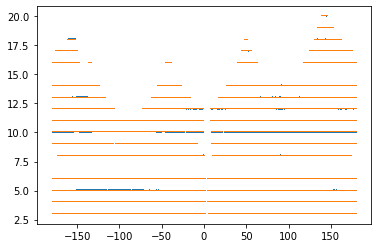

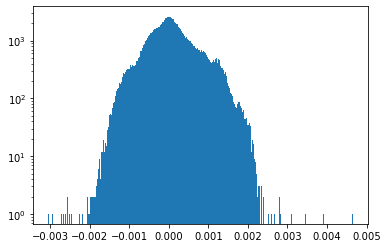

In [12]:
print('allc.shape', allc.sc.shape)
yc = calchkl2( allc, *pars )
print('yc.shape', yc.shape)


pl.figure()
pl.plot(allc.eta, yc*allc.ihkl2+allc.ihkl2, ",")
pl.plot(allc.eta,allc.ihkl2,',')
pl.figure()
pl.hist(yc,bins=1024)
pl.semilogy()

In [13]:
avgi = allc.sum_intensity / allc.Number_of_pixels   # average intensity in a peak 
# sigma = avgi/avgi.max()                             # relative weights
sigma = np.sqrt(avgi/avgi.max())

# print(np.max(avgi))
# print(np.min(sigma))
tic = time.time()
fpars, matrx = scipy.optimize.curve_fit( calchkl2,               # function to fit
                               allc,                    # 'x' argument to function 
                               np.zeros(allc.nrows),    # y_obs values (integer hkls)  
                               pars,                    # parameters to be fitted
                               sigma = sigma  )

print('time', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('toc', time.time()-tic)

time 2023-09-28 16:36:44
toc 53.5643036365509


Correlation above 80%
2:distance/a 1:distance/a 0.9680561716009319
3:distance/a 1:distance/a 0.9456111534362606
3:distance/a 2:distance/a 0.9648261277253851
3:z_center 2:z_center 0.8064866337037639
4:distance/a 1:distance/a 0.8325027136231424
4:distance/a 2:distance/a 0.8525883998388745
4:distance/a 3:distance/a 0.9282358293333354
4:y_center 3:y_center 0.8149295049849525
4:z_center 3:z_center 0.8534017043281983
a0 1:distance/a 0.8904322228180793
a0 2:distance/a 0.8634098357755117
a0 3:distance/a 0.8537979249782603
M[1,2] M[1,0] -0.8685823198055375
M[2,2] M[2,0] -0.8850461163896299
M[3,2] M[3,0] -0.9072606242861594
M[5,2] M[5,0] -0.8347410262363291
M[6,2] M[6,0] -0.8878496595583208
M[7,2] M[7,0] -0.8772868365914195
M[15,2] M[15,0] -0.906812602387579
M[16,2] M[16,0] 0.9256457938332492
M[17,2] M[17,0] 0.9025776740392264
M[20,2] M[20,0] 0.8884807334210048
M[21,2] M[21,0] 0.8335798845307862
M[24,2] M[24,0] 0.9364328006082723
M[25,2] M[25,0] 0.9561054442352743
M[26,2] M[26,0] 0.8321480577863

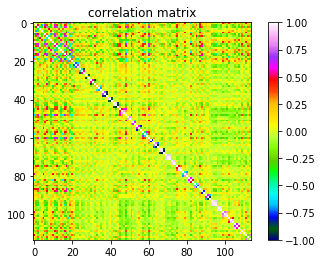

In [14]:
#print(fpars, matrx)
from datetime import datetime
pl.figure()
corr = matrx.copy()
ser = np.sqrt(np.diag(corr))
corr = corr / ser 
corr = corr.T / ser
pl.imshow(corr, cmap='gist_ncar', vmin=-1)
pl.colorbar()
pl.title("correlation matrix")
print("Correlation above 80%")
for i in range(corr.shape[0]):
    for j in range(i-1):
        if abs(corr[i,j])>0.8:
            print(pnames[i],pnames[j],corr[i,j])

[]

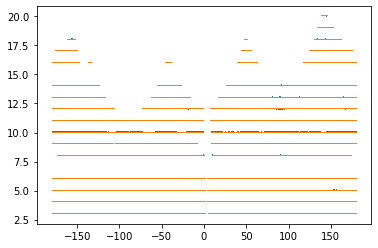

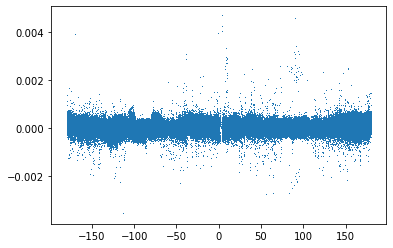

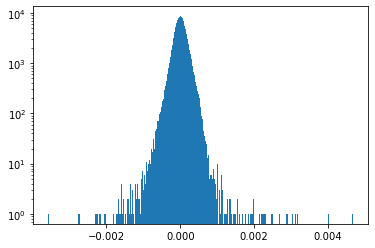

In [15]:
ycalc = calchkl2(allc, *fpars)
pl.figure()
pl.plot(allc.eta, ycalc*allc.ihkl2+allc.ihkl2, ",")
pl.plot(allc.eta,allc.ihkl2,',')
pl.figure()
pl.plot(allc.eta, ycalc, ",")
pl.figure()
pl.hist( ycalc, bins=1024)
pl.semilogy()

In [16]:
allc.filter( abs(ycalc)<.001 )


print('allc.shape', allc.sc.shape)
print('ycalc.shape', ycalc.shape)
print('type(ycalc)', type(ycalc))

allc.shape (376686,)
ycalc.shape (377128,)
type(ycalc) <class 'numpy.ndarray'>


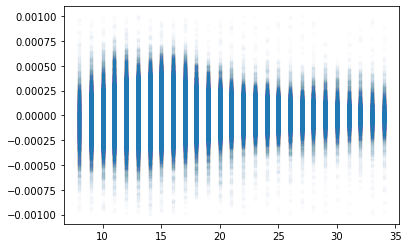

In [17]:
ycalc = calchkl2(allc, *fpars)
pl.figure()
pl.plot(allc.Number_of_pixels,ycalc,'.', alpha=0.01)

In [18]:
# repeat fitting with cleaned data
p2 = [p for p in fpars]  
tic = time.time()
fpars2, matrx2 = scipy.optimize.curve_fit( calchkl2, allc, np.zeros(allc.nrows), p2 )
print('time', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('toc', time.time()-tic)

time 2023-09-28 16:37:25
toc 39.223230838775635


[[-2.46600072e-01 -1.11650906e-01 -9.02624195e-04]
 [-4.65261418e-01  1.05731489e+00 -7.99854790e-04]
 [-1.32263340e+00  1.07233219e+00 -1.22784875e-04]
 [-7.10626911e+00 -1.84104341e+00  2.42980920e-03]
 [ 2.02393999e-01  2.18382656e+00 -1.98132525e-03]
 [-1.73886335e-01  2.21657693e+00 -6.41308146e-04]
 [-4.58048589e+00 -4.79827229e+00  2.00044068e-03]
 [-3.86481474e+00 -3.58614589e+00  1.47124435e-03]
 [-4.80095338e-01 -1.25090434e+00 -1.30785612e-03]
 [ 1.59867075e-02 -2.21577902e-01 -3.76253140e-04]
 [-3.74503397e-01  1.35195384e-01  4.07289058e-04]
 [-4.88313693e+00 -7.75617150e-01  3.23282206e-03]
 [-1.49262014e-01  3.59514799e-01 -7.84929625e-04]
 [ 4.84704530e-01  3.06179646e-01 -2.35113347e-04]
 [ 2.57525417e-01  1.69204254e-01  2.59265358e-04]
 [-2.22494547e-01 -2.24544144e-01  5.04808187e-04]
 [ 7.52834915e-01  1.81385767e-01  3.82333954e-05]
 [ 8.39146000e-01 -4.76046201e-02 -1.67228296e-04]
 [ 9.26136215e-01  1.30451249e-01 -2.60973859e-04]
 [ 9.67861907e-02  9.20272118e-

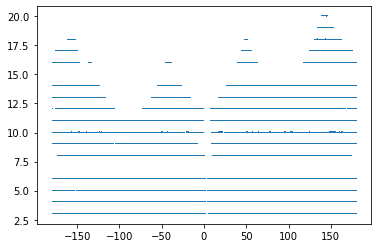

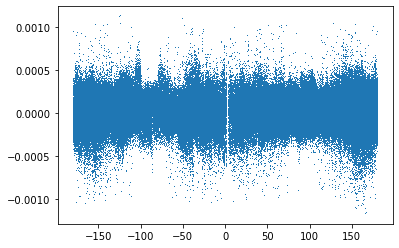

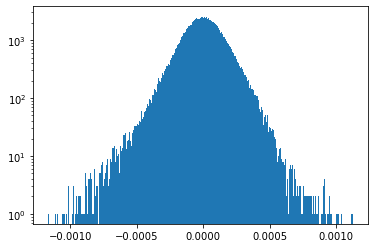

In [19]:
ycalc = calchkl2(allc, *fpars2)
pl.figure()
pl.plot(allc.eta, ycalc*allc.ihkl2+allc.ihkl2, ",")
# pl.ylim(9.98, 10.02)
pl.figure()
pl.plot(allc.eta, ycalc, ",")
pl.figure()
pl.hist( ycalc, bins=1024)
pl.semilogy()

p16 = mp31_32(fpars2[framepars:])
print(p16)

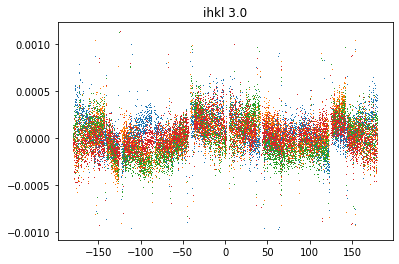

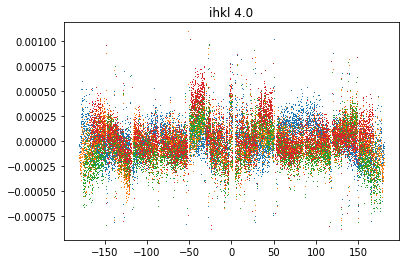

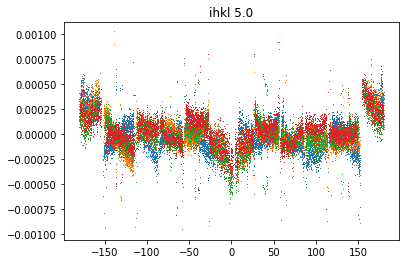

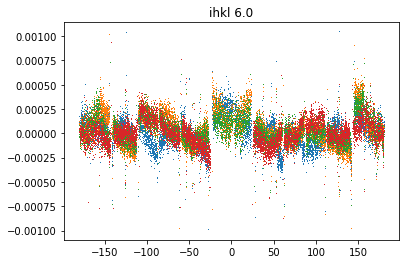

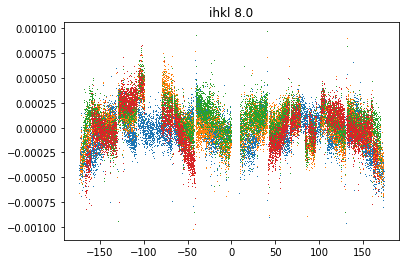

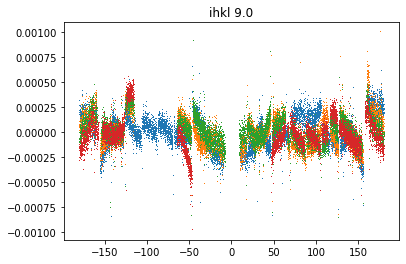

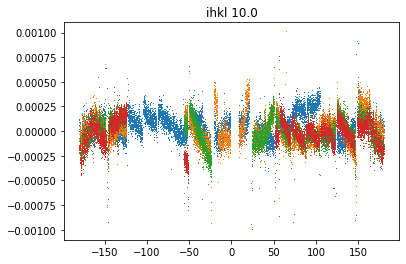

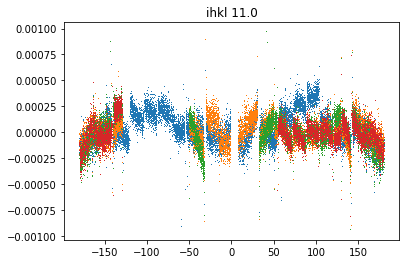

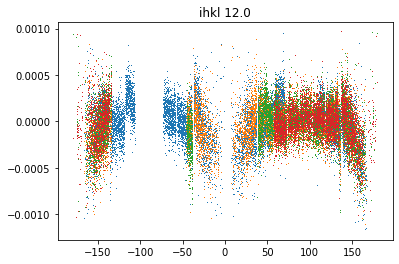

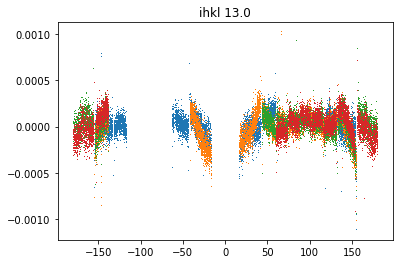

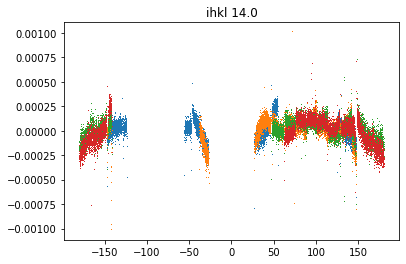

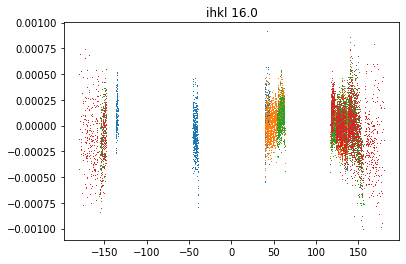

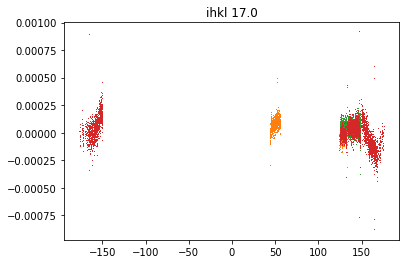

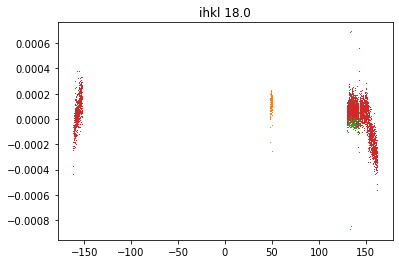

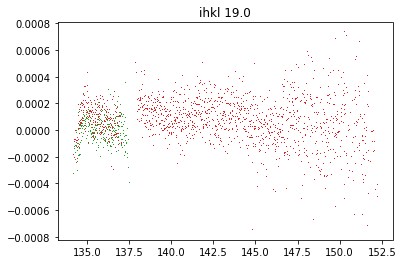

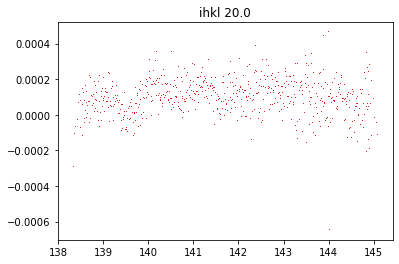

In [20]:
ycalc = calchkl2(allc, *fpars2)
rings = np.unique( np.round( allc.ihkl2 ) )
frames = np.unique( np.round( allc.frame ) )
for r in rings:
    pl.figure()
    mr = allc.ihkl2 == r
    for f in frames: 
        mf = allc.frame == f
        pl.plot(allc.eta[mr&mf], ycalc[mr&mf], ",")
    pl.title(f'ihkl {r}')

[None]

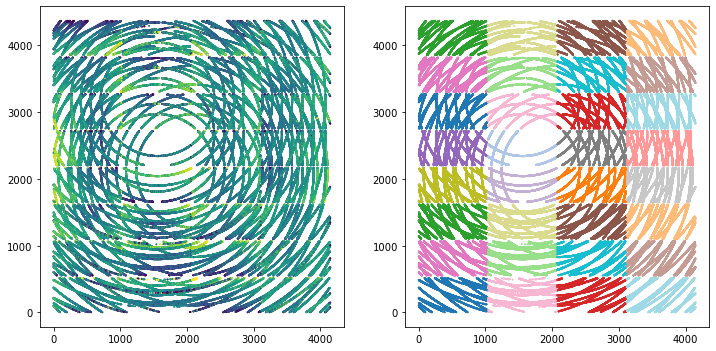

In [21]:
f, a = pl.subplots(1,2,figsize=(12,6))
a[0].scatter( allc.f_raw, allc.s_raw, c=ycalc, s=1, vmin=-5e-4, vmax=5e-4)
a[0].set(aspect='equal')
a[1].scatter( allc.f_raw, allc.s_raw, c=(allc.module*13)%20, s=1, cmap='tab20')
a[1].set(aspect='equal')

In [22]:
a0, fpars2[framepars-1],4.15682600

(4.156826, 4.158281689016619, 4.156826)

In [23]:
frms, fpars2


([1, 2, 3, 4],
 array([ 3.53794553e+01,  2.09391893e+03,  2.12009163e+03,  6.36721622e-04,
        -1.72022260e-03,  3.53860949e+01,  1.56026094e+03,  2.11996903e+03,
         6.18279212e-04, -1.30085185e-03,  3.53878251e+01,  1.56033947e+03,
         2.66095088e+03,  6.90141460e-04, -1.28490957e-03,  3.53964217e+01,
         1.56039872e+03,  3.19438373e+03,  7.90669076e-04, -1.27838296e-03,
         4.15828169e+00, -2.46600072e-01, -1.11650906e-01, -9.02624195e-04,
        -4.65261418e-01,  1.05731489e+00, -7.99854790e-04, -1.32263340e+00,
         1.07233219e+00, -1.22784875e-04, -7.10626911e+00, -1.84104341e+00,
         2.42980920e-03,  2.02393999e-01,  2.18382656e+00, -1.98132525e-03,
        -1.73886335e-01,  2.21657693e+00, -6.41308146e-04, -4.58048589e+00,
        -4.79827229e+00,  2.00044068e-03, -3.86481474e+00, -3.58614589e+00,
         1.47124435e-03, -4.80095338e-01, -1.25090434e+00, -1.30785612e-03,
         1.59867075e-02, -2.21577902e-01, -3.76253140e-04, -3.74503397e-0

In [24]:
# Write spatially corrected files



a0 = fpars2[framepars-1]
for i in frms:
    p = read_par_file("eigerSpatial/par/%d_fit.par"%(i))
    k = i-1
    p.parameters.update( {'distance' : fpars2[k*5]*a0,
                          'y_center' : fpars2[k*5+1],
                          'z_center' : fpars2[k*5+2],
                          'tilt_y' : fpars2[k*5+3],
                          'tilt_z' : fpars2[k*5+4] } )
    p.saveparameters("eigerSpatial/par/%ds.par"%(i))


for n,v in zip(pnames, fpars2):
    print(n,v)

1:distance/a 35.37945534537952
1:y_center 2093.918931326497
1:z_center 2120.09162660413
1:tilt_y 0.0006367216222615916
1:tilt_z -0.001720222597011038
2:distance/a 35.386094881343055
2:y_center 1560.260940745482
2:z_center 2119.96903172491
2:tilt_y 0.0006182792122466031
2:tilt_z -0.0013008518458709265
3:distance/a 35.38782505909785
3:y_center 1560.3394709159609
3:z_center 2660.9508785597823
3:tilt_y 0.0006901414603271921
3:tilt_z -0.001284909573423888
4:distance/a 35.39642169550359
4:y_center 1560.3987223744814
4:z_center 3194.3837311778466
4:tilt_y 0.000790669075763154
4:tilt_z -0.0012783829574033695
a0 4.158281689016619
M[0,0] -0.2466000719095419
M[0,1] -0.11165090560879926
M[0,2] -0.0009026241946113138
M[1,0] -0.46526141766266405
M[1,1] 1.0573148912521777
M[1,2] -0.0007998547898431232
M[2,0] -1.3226333950463998
M[2,1] 1.0723321879999568
M[2,2] -0.00012278487537705038
M[3,0] -7.10626911448442
M[3,1] -1.8410434072453212
M[3,2] 0.002429809203254606
M[4,0] 0.202393999150036
M[4,1] 2.1838

(4371, 4150)
(4371, 4150)
[[   0    1    2 ... 4147 4148 4149]
 [   0    1    2 ... 4147 4148 4149]
 [   0    1    2 ... 4147 4148 4149]
 ...
 [   0    1    2 ... 4147 4148 4149]
 [   0    1    2 ... 4147 4148 4149]
 [   0    1    2 ... 4147 4148 4149]]
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [4368 4368 4368 ... 4368 4368 4368]
 [4369 4369 4369 ... 4369 4369 4369]
 [4370 4370 4370 ... 4370 4370 4370]]
(4371, 4150)


<ipython-input-25-1b420f79a3db>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros(s.shape, np.int)-1


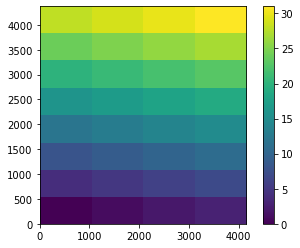

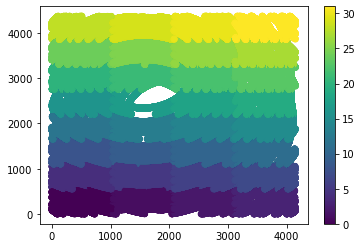

In [25]:
# Verify and create conventional distortion files
s, f = np.mgrid[0:4371,0:4150]

print(s.shape)
print(f.shape)
print(f)
print(s)
m = np.zeros(s.shape, np.int)-1
print(m.shape)
#    fs = 1030
#    ss = 514
#    fo = [ 0,  10,   20,   30]
#    so = [ 0, 37, 2*37, 37*3, 37*4, 37*5, 37*6, 37*7]
for i in range(8):
    for j in range(4):
        a = module(m,i,j)
        a[:,:] = i*4+j
# Make an image of which module is this pixel
# fill gaps: ... yes, this could be more elegant
m[514:514+37//2,:]=m[513,:]
m[514+37//2:514+37,:]=m[514+37+1,:]

m[514*2+37:514*2+37+37//2,:]=m[514*2+37-1,:]
m[514*2+37+37//2:514*2+37*2,:]=m[514*2+2*37+1,:]

m[514*3+37*2:514*3+37*2+37//2,:]=m[514*3+37*2-1,:]
m[514*3+37*2+37//2:514*3+37*3,:]=m[514*3+3*37+1,:]

m[514*4+37*3:514*4+37*3+37//2,:]=m[514*4+3*37-1,:]
m[514*4+37*3+37//2:514*4+37*4,:]=m[514*4+4*37+1,:]

m[514*5+37*4:514*5+37*4+37//2,:]=m[514*5+4*37-1,:]
m[514*5+37*4+37//2:514*5+37*5,:]=m[514*5+5*37+1,:]

m[514*6+37*5:514*6+37*5+37//2,:]=m[514*6+5*37-1,:]
m[514*6+37*5+37//2:514*6+37*6,:]=m[514*6+6*37+1,:]

m[514*7+37*6:514*7+37*6+37//2,:]=m[514*7+6*37-1,:]
m[514*7+37*6+37//2:514*7+37*7,:]=m[514*7+7*37+1,:]


m[:,1028:1034]=m[:,1025][:,np.newaxis]
m[:,1033:1040]=m[:,1041][:,np.newaxis]

m[:,2068:2074]=m[:,2065][:,np.newaxis]
m[:,2073:2080]=m[:,2081][:,np.newaxis]

m[:,3108:3114]=m[:,3105][:,np.newaxis]
m[:,3113:3120]=m[:,3211][:,np.newaxis]

# verify we did not mess up the real pixels:
for i in range(8):
    for j in range(4):
        a = module(m,i,j)
        assert((a[:,:] == i*4+j).all())
pl.figure()
pl.imshow(m, origin='lower')
pl.colorbar()
pl.figure()
pl.scatter(allc.fc, allc.sc, c=allc.module )
pl.colorbar()


In [26]:
# full image spatial:
sc,fc = do_spatial(s.ravel(),f.ravel(),m.ravel(), p16)
sc.shape=s.shape
fc.shape=f.shape
ds = sc - s      # LUT
df = fc - f      # 

fabio.edfimage.edfimage((fc-f).astype(np.float32)).write("e2dx.edf")
fabio.edfimage.edfimage((sc-s).astype(np.float32)).write("e2dy.edf")





df = fabio.open("e2dx.edf").data
ds = fabio.open("e2dy.edf").data

In [28]:
import ImageD11.transformer

<ipython-input-29-b14516394f7d>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.figure()


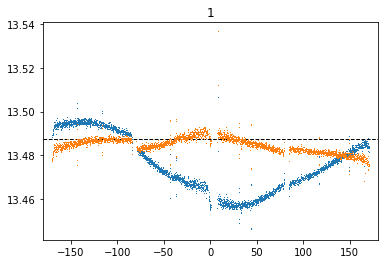

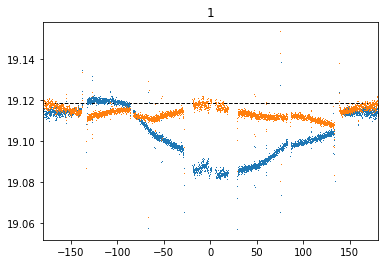

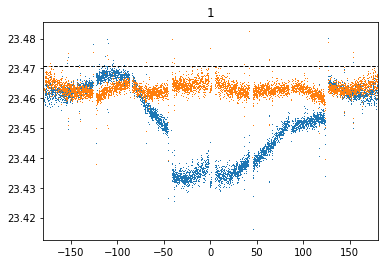

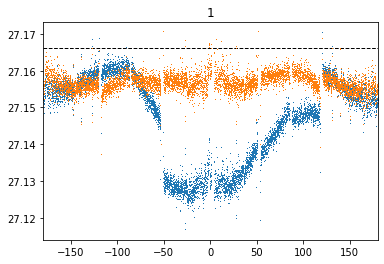

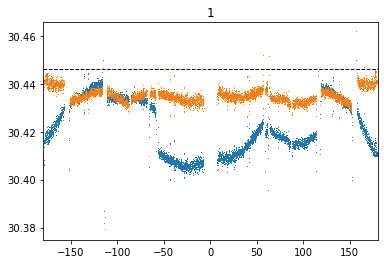

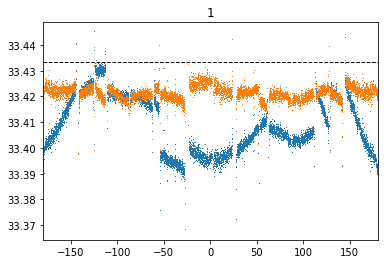

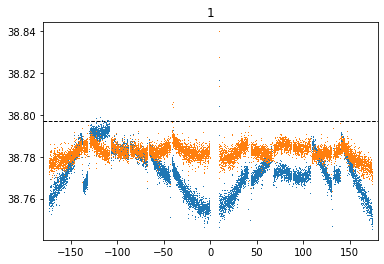

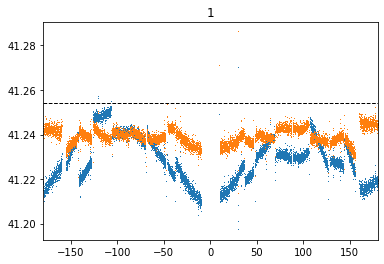

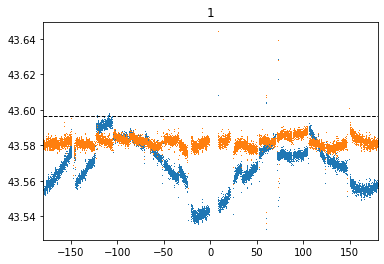

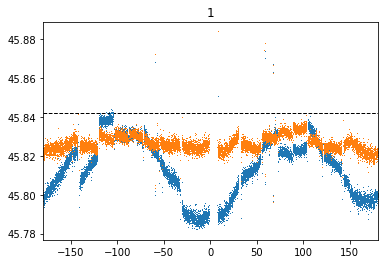

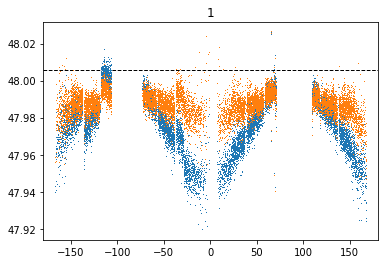

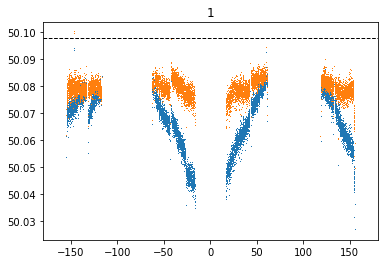

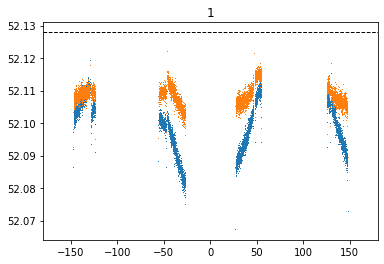

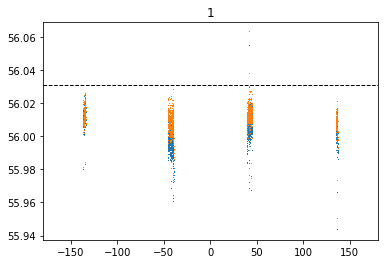

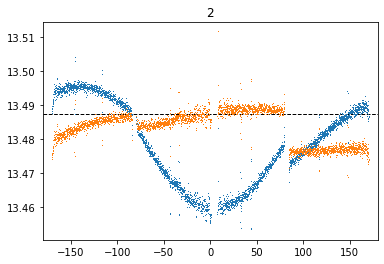

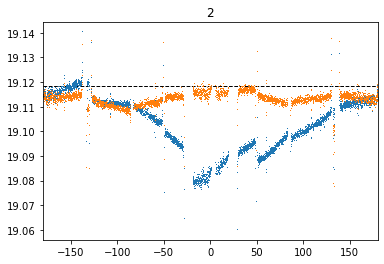

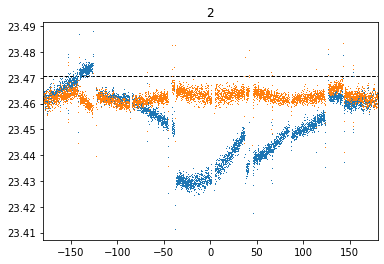

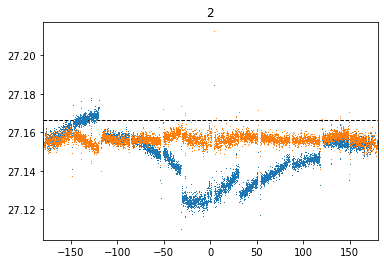

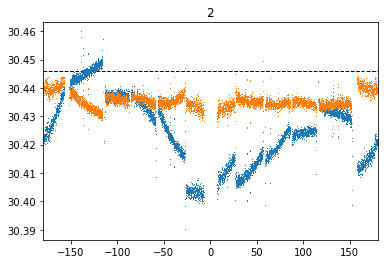

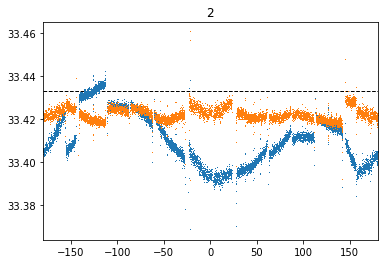

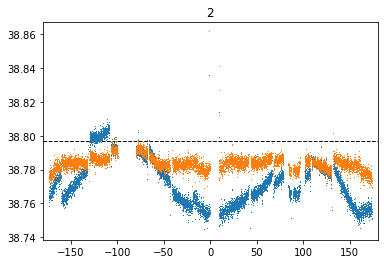

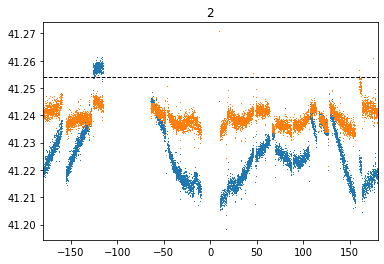

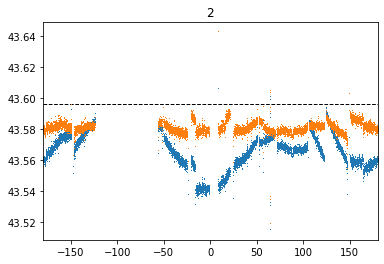

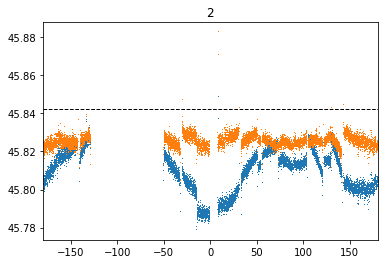

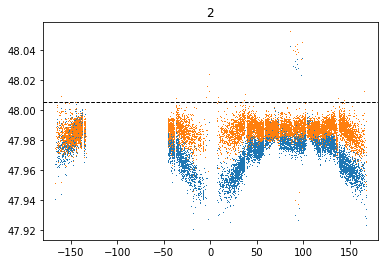

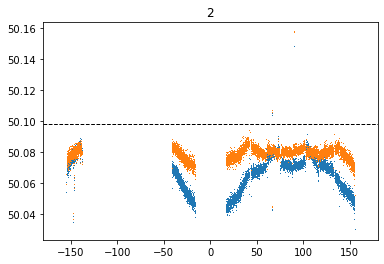

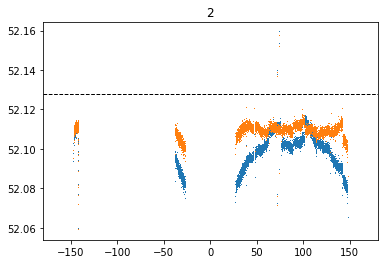

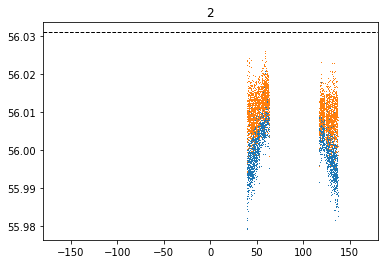

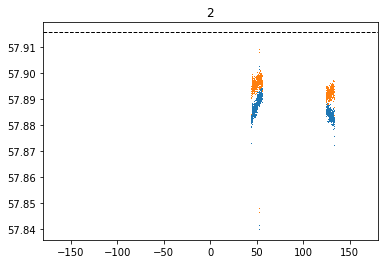

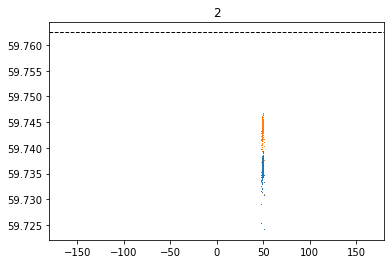

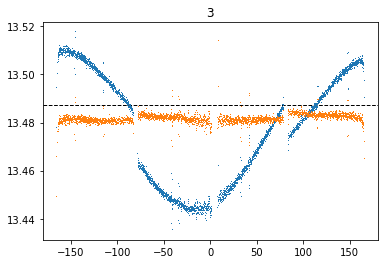

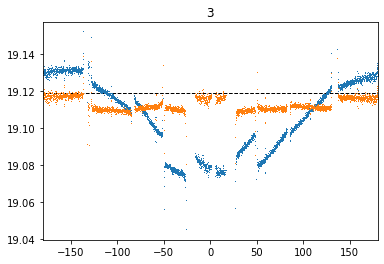

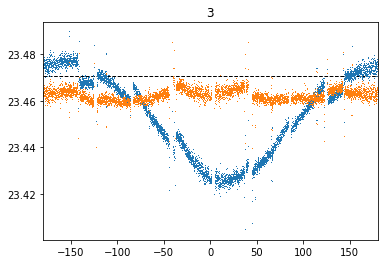

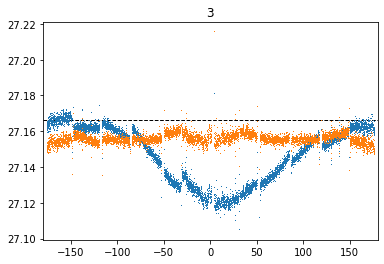

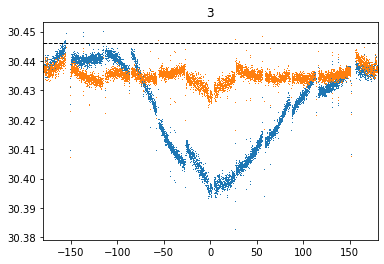

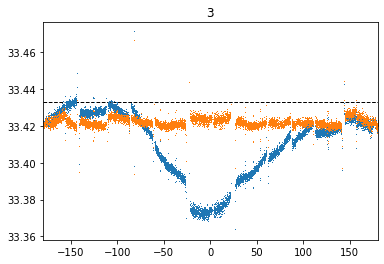

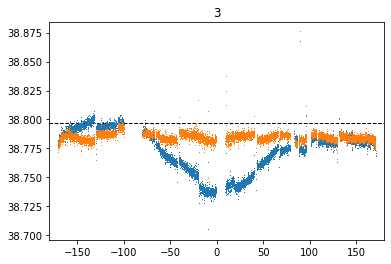

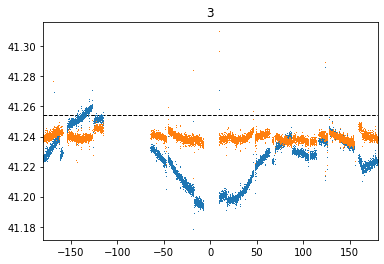

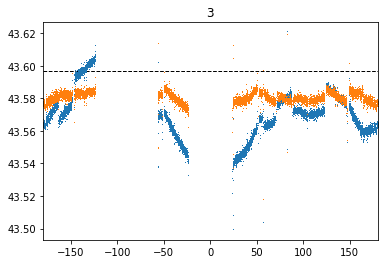

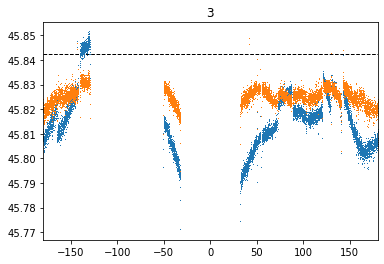

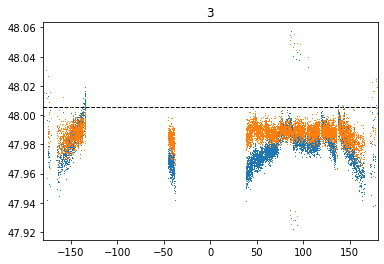

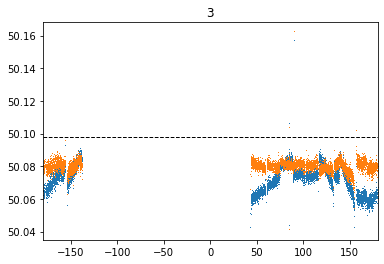

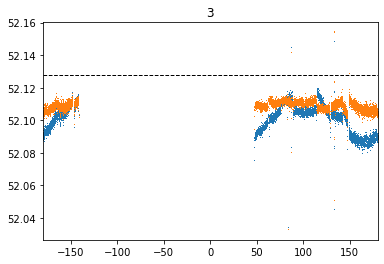

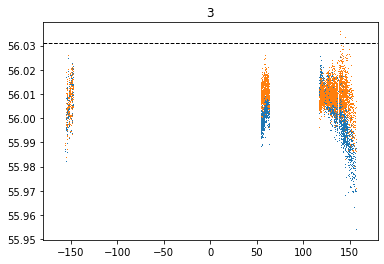

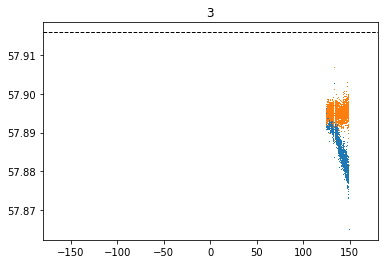

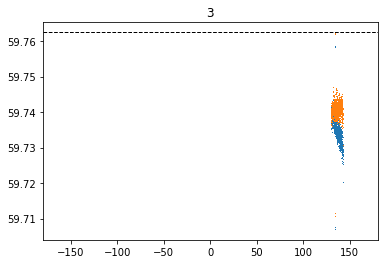

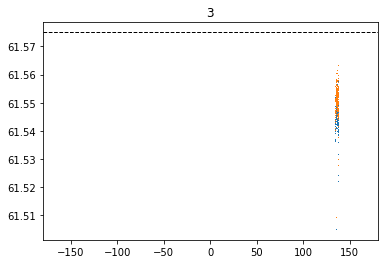

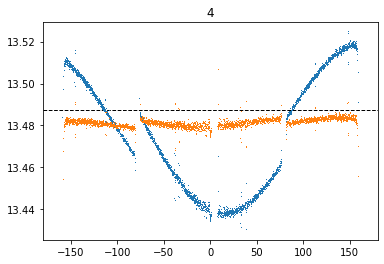

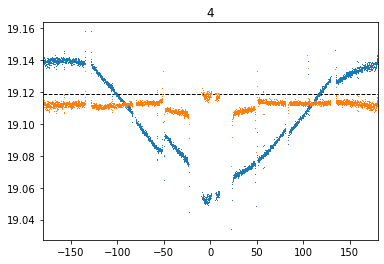

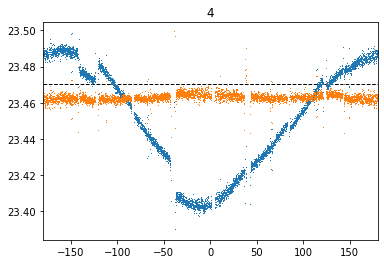

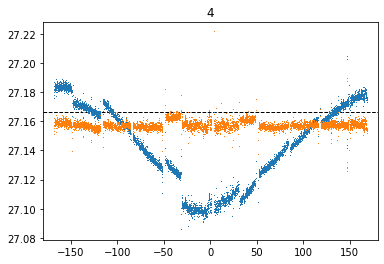

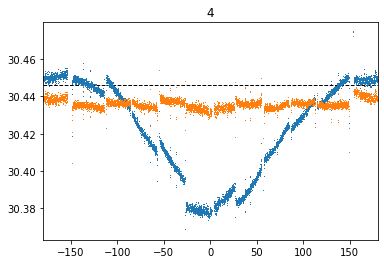

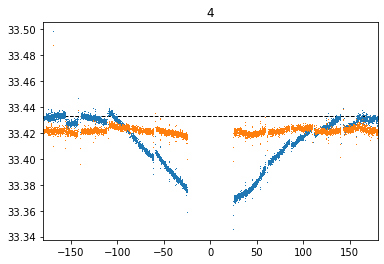

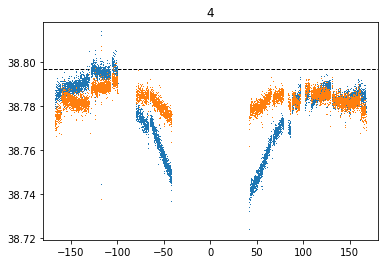

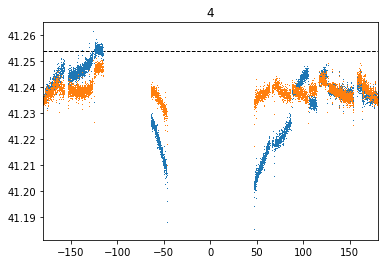

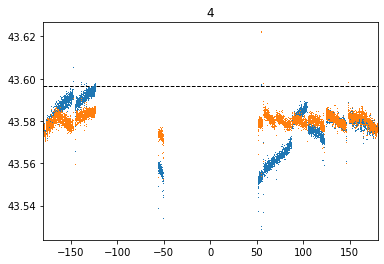

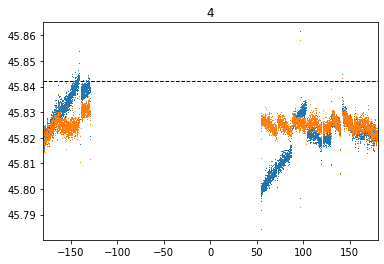

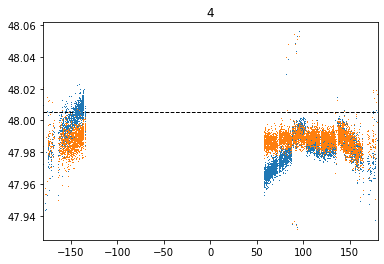

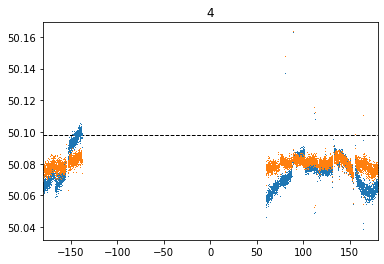

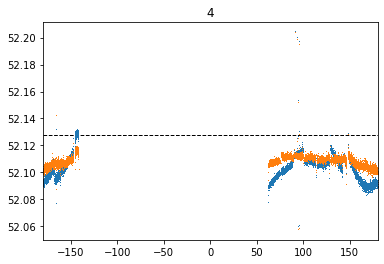

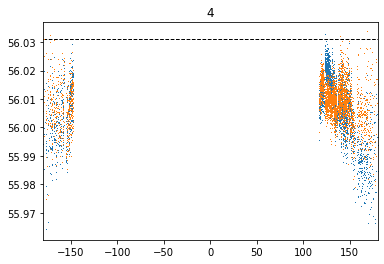

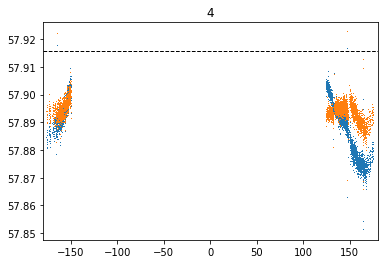

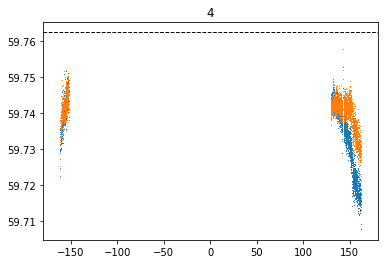

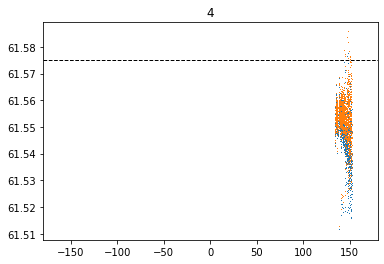

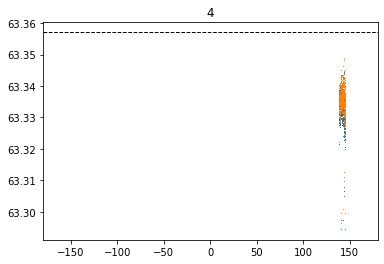

In [29]:
for i in range(1,5):
    t=ImageD11.transformer.transformer()
    t.loadfiltered(f"eigerSpatial/flt/{i}_clean.flt")
    t.loadfileparameters(f"eigerSpatial/par/{i}s.par")
    t.colfile.sc[:] = t.colfile.s_raw[:]
    t.colfile.fc[:] = t.colfile.f_raw[:]
    t0, e0 = t.compute_tth_eta()
    t.addcellpeaks()
    for tth in t.theorytth:
        pl.figure()
        pl.hlines(y=tth, xmin=-180,xmax=180, linewidth=1, color='k', linestyles='dashed', label='Calculated')
        m = abs(t.colfile.tth - tth ) < 0.1
        pl.plot(e0[m],t0[m],",", label='Before correction')
        
        si = np.round( t.colfile.s_raw ).astype(int)
        fi = np.round( t.colfile.f_raw ).astype(int)
        t.colfile.sc[:] = t.colfile.s_raw[:] + ds[ si, fi ]
        t.colfile.fc[:] = t.colfile.f_raw[:] + df[ si, fi ]
        t.compute_tth_eta()
        pl.plot(t.colfile.eta[m],t.colfile.tth[m],",", label='After correction')
        pl.title(i)
        pl.xlim(-180,180)

<ipython-input-35-afe73546d47c>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.figure()


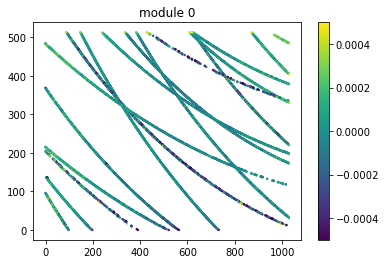

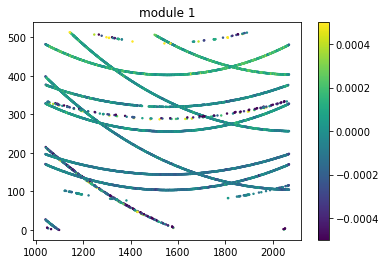

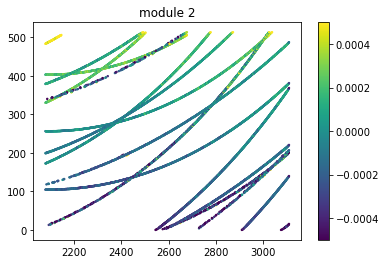

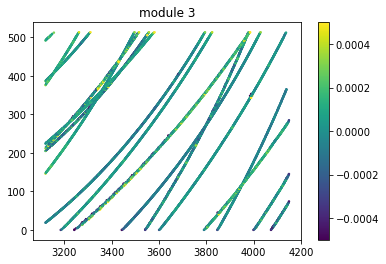

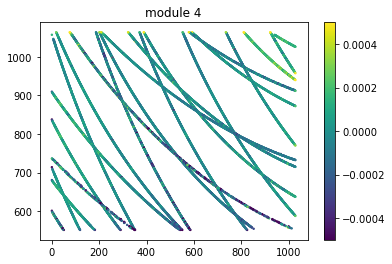

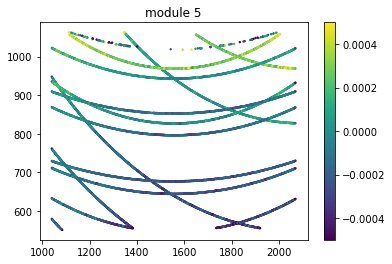

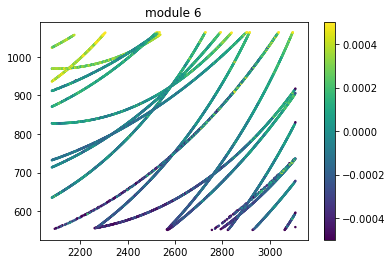

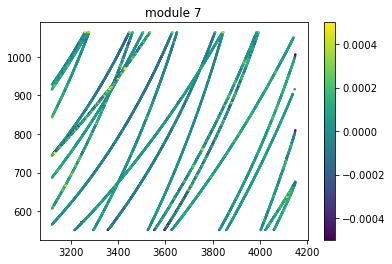

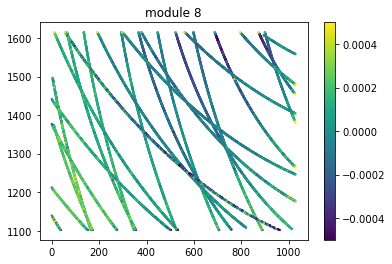

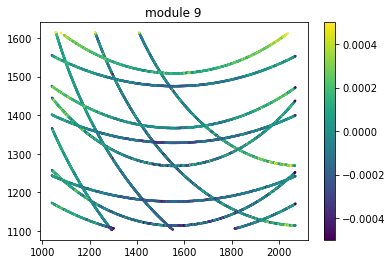

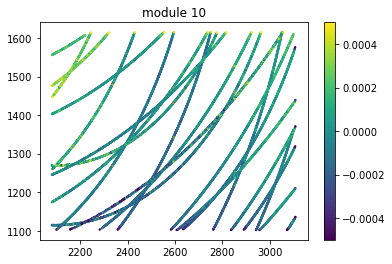

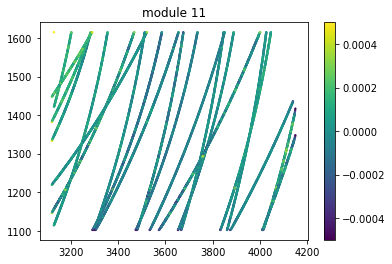

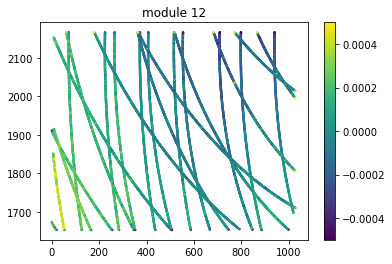

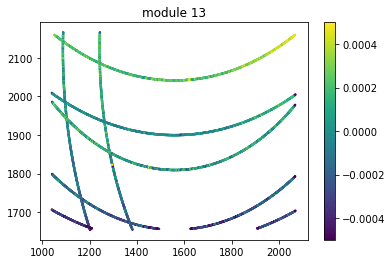

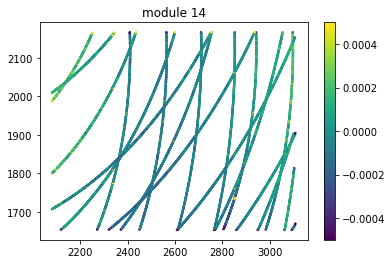

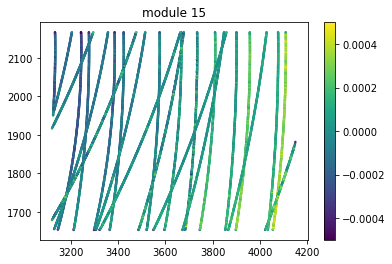

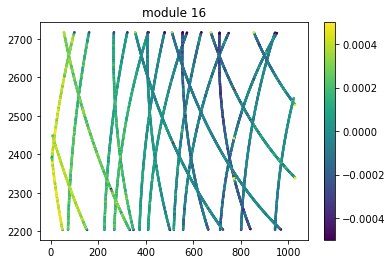

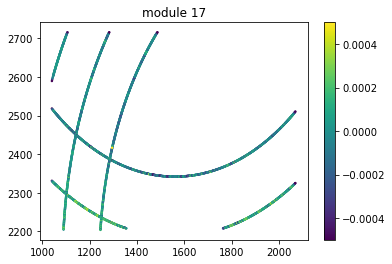

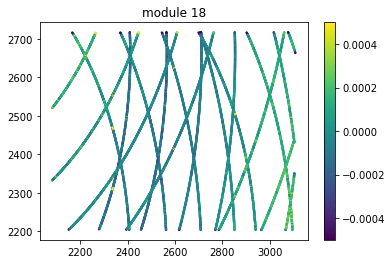

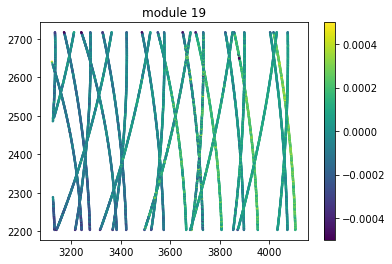

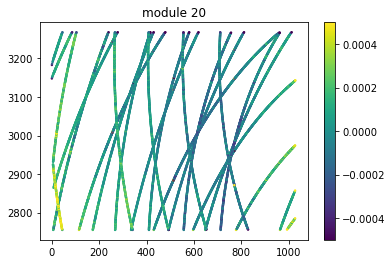

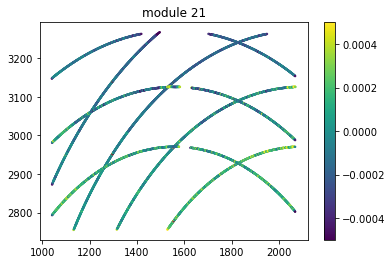

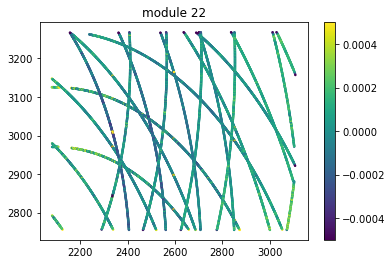

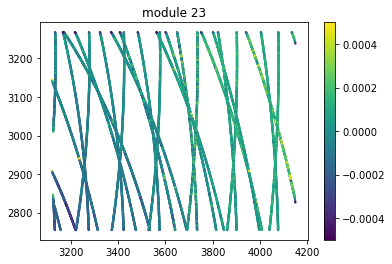

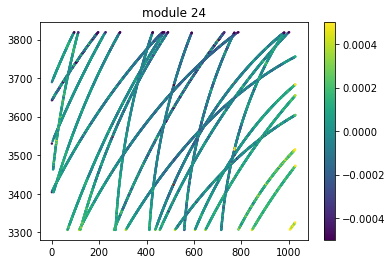

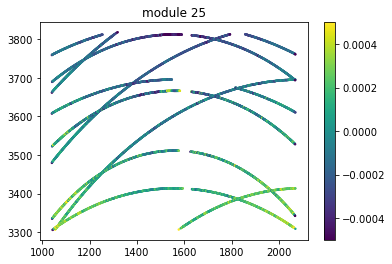

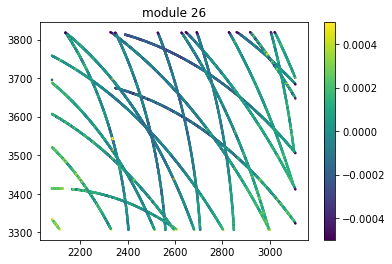

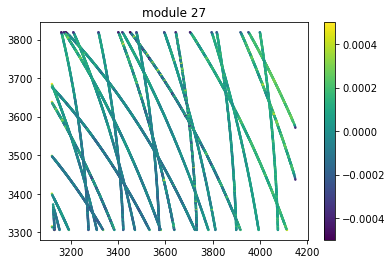

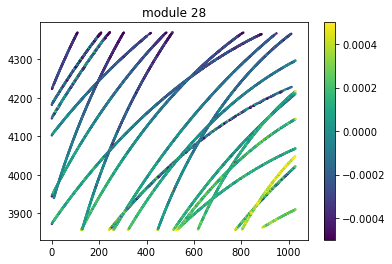

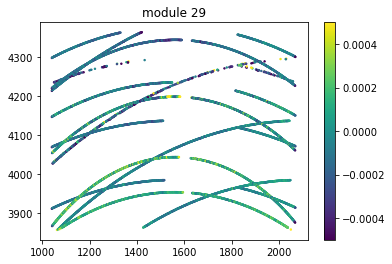

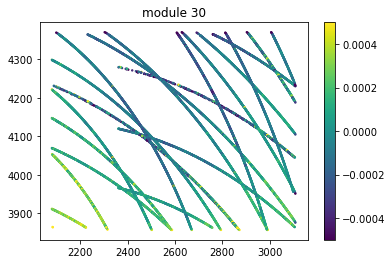

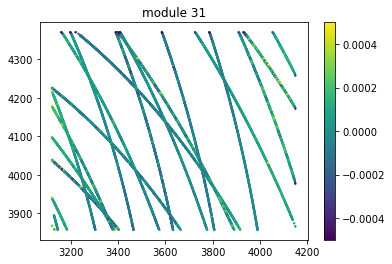

In [35]:
for i in range(32):
    m = allc.module == i
    pl.figure()
    pl.scatter( allc.f_raw[m], allc.s_raw[m], c=ycalc[m], vmin=-5e-4, vmax=5e-4, s = 2)
    pl.colorbar()
    pl.title(f'module {i}')